# Importing required libraries

In [1]:
!pip install datasets

In [2]:
#importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
import string,re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer
from datasets import load_dataset, DatasetDict, load_metric, Dataset  # Importing functions from Hugging Face datasets library
from transformers import  Trainer, TrainingArguments,BertForSequenceClassification

In [3]:
nltk.download('stopwords') # download stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Read the Data**

In [5]:
# read the csv files
df=pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


# Clean the data

In [8]:
df.isna().sum() # sum of null values

review       0
sentiment    0
dtype: int64

In [9]:
df['review'].duplicated().sum() # sum of duplicate values

418

In [10]:
rev = df['review']
dup = df[rev.isin(rev[rev.duplicated()])].sort_values("review") # save the duplicate values

In [11]:
df = df.drop(dup.index)# removing the duplicate values
df.reset_index(drop = True)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49171,I thought this movie did a down right good job...,positive
49172,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49173,I am a Catholic taught in parochial elementary...,negative
49174,I'm going to have to disagree with the previou...,negative


In [12]:
stop = set(stopwords.words('english')) # Create a set of English stopwords
punctuations = list(string.punctuation)
stop.update(punctuations)

In [13]:
def strip_html(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()
def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)
def remove_https(text):
    return re.sub(r'https\S+', '', text)
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
def clean_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [14]:
df['review'] = df['review'].apply(clean_text)

<ipython-input-13-1f37e40e6dfd>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [15]:
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,positive
1,wonderful little filming technique fashion giv...,positive
2,thought wonderful way spend time hot summer si...,positive
3,basically family little boy thinks zombie clos...,negative
4,petter time visually stunning film mattei offe...,positive


# EDA

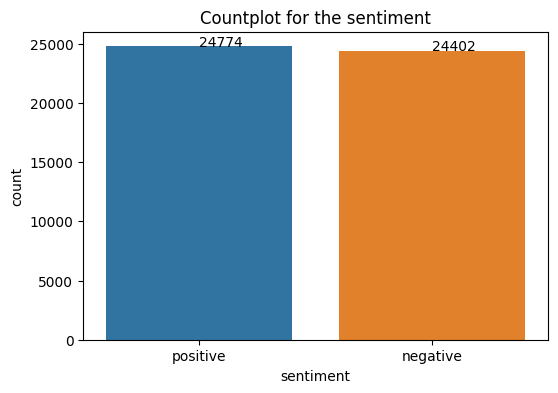

In [ ]:
# plot countplot for distribution of dataset
plt.figure(figsize = (6,4))
sns.countplot(x='sentiment', data = df, hue='sentiment')
plt.annotate(df[df['sentiment']=='positive'].count()['sentiment'], ('positive', df[df['sentiment']=='positive'].count()['sentiment']))
plt.annotate(df[df['sentiment']=='negative'].count()['sentiment'], ('negative', df[df['sentiment']=='negative'].count()['sentiment']))
plt.title('Countplot for the sentiment')
plt.show()

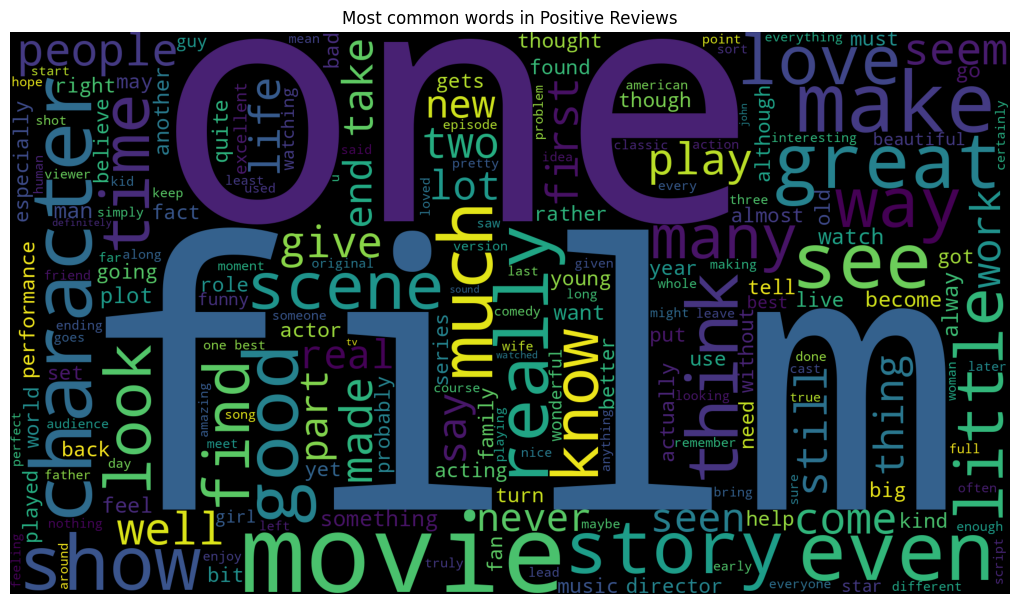

In [ ]:
# Generate a word cloud image for positive sentiment reviews
wordcloud = WordCloud(width=1920,height=1080).generate(" ".join(df[df.sentiment=='positive'].review))
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Most common words in Positive Reviews')
plt.show()

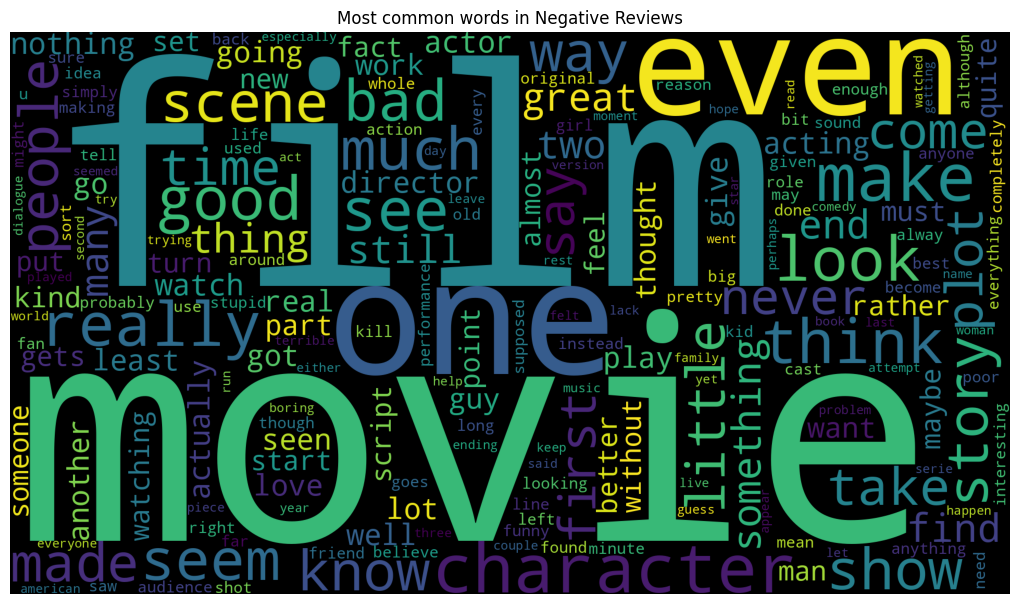

In [ ]:
# Generate a word cloud image for negative sentiment reviews
wordcloud = WordCloud(width=1920,height=1080).generate(" ".join(df[df.sentiment=='negative'].review))
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Most common words in Negative Reviews')
plt.show()

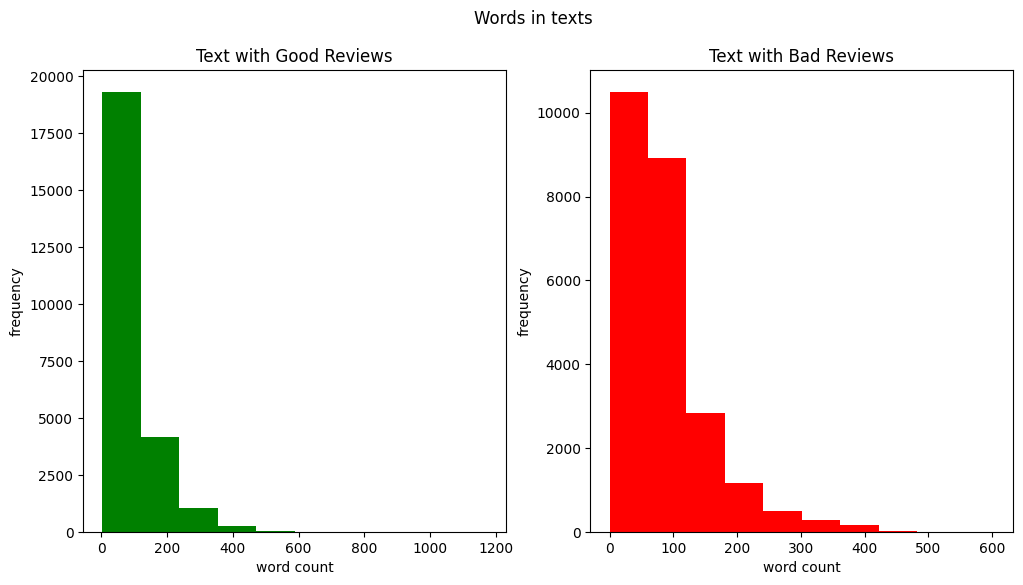

In [ ]:
# bar plot for word count
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
text_len=df[df['sentiment']=='positive']['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Text with Good Reviews')
ax1.set_xlabel('word count')
ax1.set_ylabel('frequency')
text_len=df[df['sentiment']=='negative']['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Text with Bad Reviews')
ax2.set_xlabel('word count')
ax2.set_ylabel('frequency')
fig.suptitle('Words in texts')
plt.show()

In [ ]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
most_common_bi = get_top_text_ngrams(df.review,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words", "Count"])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())

most_common_tri = get_top_text_ngrams(df.review,20,3)
most_common_tri = dict(most_common_tri)
temp1 = pd.DataFrame(columns = ["Common_words", "Count"])
temp1["Common_words"] = list(most_common_tri.keys())
temp1["Count"] = list(most_common_tri.values())

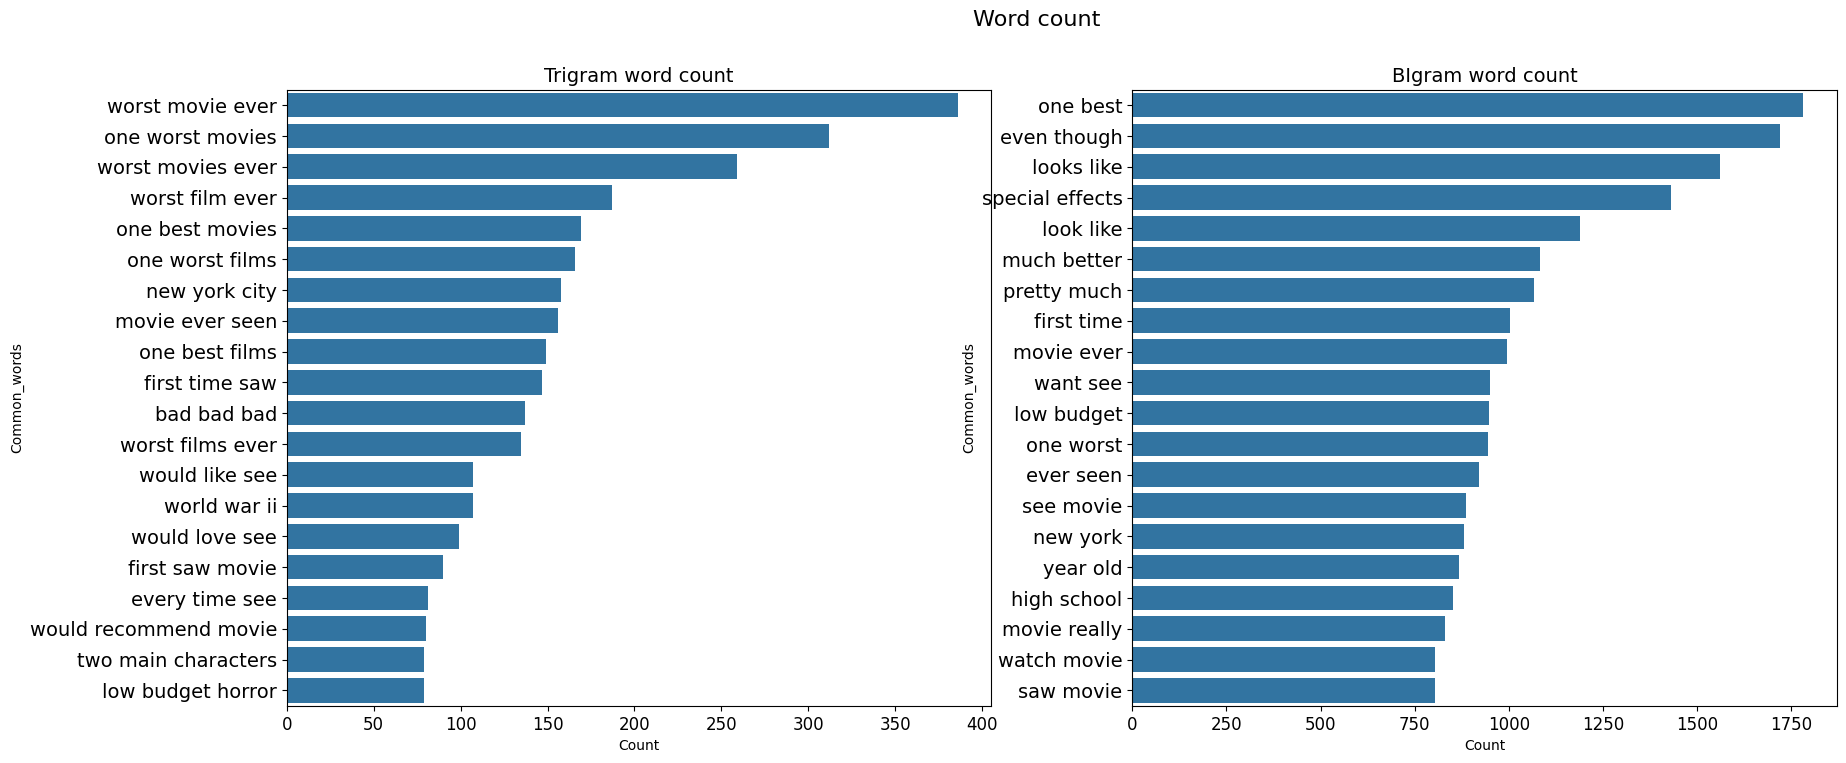

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,8))
sns.barplot(temp1, x="Count", y="Common_words", ax = ax1)
ax1.tick_params(axis = 'x', labelsize = 12)
ax1.tick_params(axis = 'y', labelsize = 14)
ax1.set_title('Trigram word count', fontsize = 14)
sns.barplot(temp, x="Count", y="Common_words", ax = ax2)
ax2.tick_params(axis = 'x', labelsize = 12)
ax2.tick_params(axis = 'y', labelsize = 14)
ax2.set_title('BIgram word count', fontsize = 14)
fig.suptitle('Word count', fontsize=16)
plt.show()

In [16]:
df.columns = ['text','labels']
df.labels.replace("positive",1,inplace=True)
df.labels.replace("negative",0,inplace=True)

# Data Preprocessing

In [17]:
# !pip install -q transformers!pip install -q accelerate
!pip install -q transformers[torch] accelerate
import accelerate

In [18]:
# Split the initial dataset into training and test sets
train, test= train_test_split(df, test_size=0.2, random_state=42)

In [19]:
# Initialize the tokenizer with the BERT base model, setting it to lowercase the text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [20]:
# Further split the test set to create a validation set
test, val = train_test_split(test, test_size=0.20, random_state=42)

In [21]:
# Further split the test set to create a validation set
train = Dataset.from_pandas(train)
test = Dataset.from_pandas(test)
validation = Dataset.from_pandas(val)
# Create a dictionary to hold the split datasets, organizing them by training, testing, and validation
dataset = DatasetDict({
    'train': train,
    'test': test,
    'val' : validation
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 39340
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 7868
    })
    val: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 1968
    })
})

In [22]:
def preprocessing(ex):
  # take a batch of texts
  text = ex["text"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=256)
  # add labels
  encoding["labels"] = ex['labels']
  return encoding

In [23]:
# Apply the preprocessing function to the dataset in batches for efficiency
encoded_dataset = dataset.map(preprocessing, batched=True)

Map:   0%|          | 0/39340 [00:00<?, ? examples/s]

Map:   0%|          | 0/7868 [00:00<?, ? examples/s]

Map:   0%|          | 0/1968 [00:00<?, ? examples/s]

# Modeling and Fine Tunning

In [24]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy = "epoch",   # Evaluate after each epoch
    save_strategy='epoch',           # Save the model after each epoch
    num_train_epochs=1,              # total number of training epochs
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,                # Log every n number of steps
    prediction_loss_only = True
)

In [25]:
def train_model(training_args, encoded_dataset):
  # Load BertForSequenceClassification, the pretrained BERT model with a single
  # linear classification layer on top.
  model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
  )

  trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=encoded_dataset["train"], #setting the data for training
    eval_dataset=encoded_dataset["test"], #using testing data to evaluate the model
    tokenizer=tokenizer,
  )
  # Start the training process
  trainer.train()
  return trainer
trainer = train_model(training_args, encoded_dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.160300,0.328201


Text(0.5, 1.0, 'Loss History')

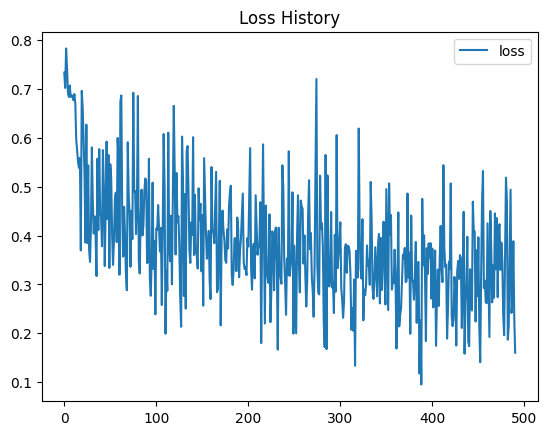

In [26]:
log_df=pd.DataFrame(trainer.state.log_history)
log_df[["loss"]].plot()
plt.title("Loss History")

# Model Evaluation and Prediction

In [30]:
checkpoints=! ls results   #saving checkpoints

In [31]:
checkpoints=checkpoints[0].split()   #creating list of checkpoints

In [32]:
saved_model = pipeline('text-classification',
                       model = 'results/'+checkpoints[-1])  #loading latest checkpoing

In [33]:
predictions = saved_model(encoded_dataset['val']['text'])
def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in predictions]

In [40]:
acc = accuracy_score(encoded_dataset['val']['labels'], predictions)

In [41]:
from sklearn.metrics import precision_score, recall_score
# Calculate precision
precision = precision_score(encoded_dataset['val']['labels'], predictions)
# Calculate recall
recall = recall_score(encoded_dataset['val']['labels'], predictions)

In [42]:
f1 = f1_score(encoded_dataset['val']['labels'], predictions, average = 'macro')

In [43]:
print(f'Accuracy = {acc}')
print(f"Precision = {precision:.4f}")
print(f"Recall = {recall:.4f}")

Accuracy = 0.8704268292682927
Precision = 0.8646
Recall = 0.8876


In [44]:
print(classification_report(encoded_dataset['val']['labels'], predictions))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       954
           1       0.86      0.89      0.88      1014

    accuracy                           0.87      1968
   macro avg       0.87      0.87      0.87      1968
weighted avg       0.87      0.87      0.87      1968



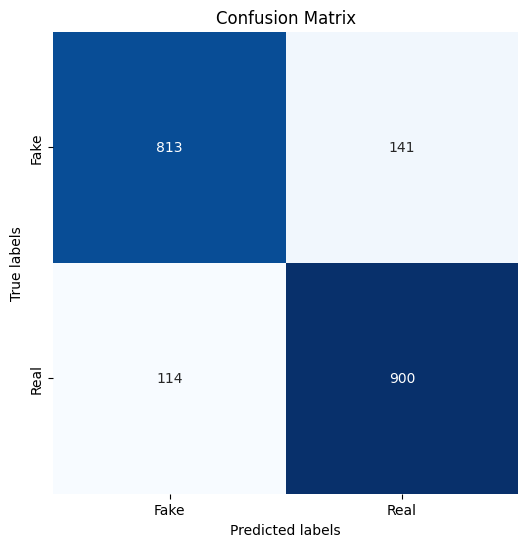

In [45]:
cm = confusion_matrix(encoded_dataset['val']['labels'], predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Fake", "Real"],
            yticklabels=["Fake", "Real"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()